# Permutation Importance 
This method involves randomly shuffling the values of a single feature and measuring the decrease in the model's performance. The idea is that if a feature is important, its absence will significantly degrade the model's performance

In [15]:
import os
import IPython
import numpy as np
import pandas as pd
from tqdm import tqdm
import IPython.display
import matplotlib.pyplot as plt


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # disable info log from tensorflow
import tensorflow as tf
from modules.kerasGenerator import CustomDataGen
from modules.DatasetWrapper import Dataset
from modules.TrainOnOneSite import Trainer

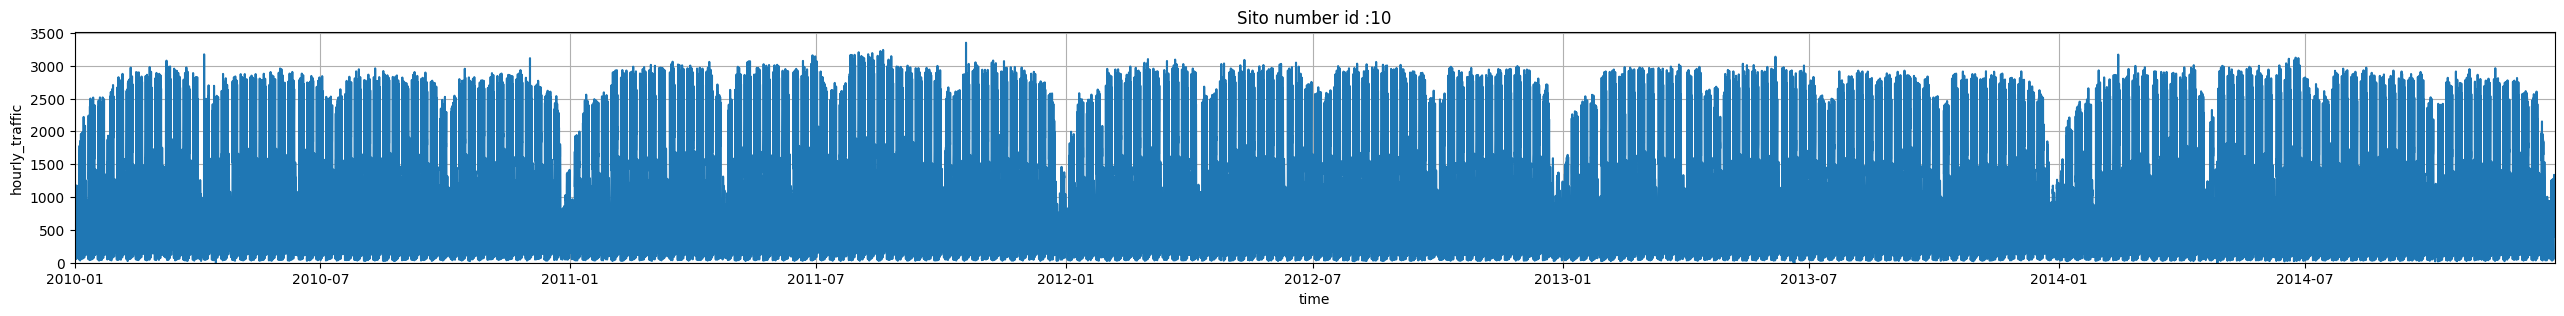

,mean,std,min,25%,50%,75%,max
hourly_traffic,0.548256,0.427252,0.000000,0.134444,0.472222,0.882778,1.861111
temperature_2m,0.833086,0.301616,0.117000,0.612000,0.774500,1.004500,2.019500
apparent_temperature,0.721823,0.344139,-0.049737,0.465404,0.656857,0.925835,2.071331
relative_humidity_2m,0.657317,0.197985,0.081371,0.516910,0.679468,0.820077,1.000000
precipitation,0.010049,0.049863,0.000000,0.000000,0.000000,0.000000,1.560000
wind_speed_10m,1.068027,0.514500,0.000000,0.686417,1.012845,1.399428,3.755674
cloud_cover,0.338667,0.311726,0.000000,0.030000,0.288000,0.558000,1.000000


Site type: SIGNALISED_4_WAY_INTERSECTION


In [2]:
data = Dataset()
_ = data.select_site(10)

In [10]:
X_col = [
    "hourly_traffic",
    "hour_of_day(sin)",
    "hour_of_day(cos)",
    "day_of_week(sin)",
    "day_of_week(cos)",
    "holiday",
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "precipitation",
    "wind_speed_10m",
    "cloud_cover",
]
input_with = 10
_, ValGen, _ = data.split_and_get_generators(
    training=3, validation=1, test=1, input_size=10, X_col=X_col
)

In [11]:
model = tf.keras.models.load_model("./models/Tuned_LSTM_1.keras")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 256)        │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,451,845 (9.35 MB)

 Trainable params: 817,281 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,634,564 (6.24 MB)

In [ ]:
results = []
metric = "RMSE"
iterations = 15
# -- -- -- --
#print(f"Calcolo {metric} Baseline")
baseline = np.sqrt(ValGen.compute_metrics(model.predict(ValGen, verbose=0),1800)["mean_squared_error"])
results.append({"feature": "BASELINE", metric: baseline})
# -- -- -- --
for k in X_col:
    # print(f"Calcolo mea per shuffle della feature ---> {k}")
    error_sum = 0
    # SHUFFLE FEATURE K
    df_copy = ValGen.df.copy()
    for _ in range(10):
        df_copy[k] = np.random.permutation(df_copy[k]).tolist()
    
    Gen = CustomDataGen(
        df_copy,
        X_col,
        ValGen.y_col,
        ValGen.batch_size,
        ValGen.input_width,
        ValGen.label_width,
    )

    mea_sum = 0
    for _ in tqdm(range(iterations),desc=k):
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        error = np.sqrt(Gen.compute_metrics(model.predict(Gen, verbose=0),1800)["mean_squared_error"])
        error_sum += error

    error_avg = error_sum / iterations  # Calculate the average MAE
    results.append({"feature": k, metric: error_avg})
del df_copy, Gen

results = pd.DataFrame(results)
IPython.display.clear_output(wait=True)
results

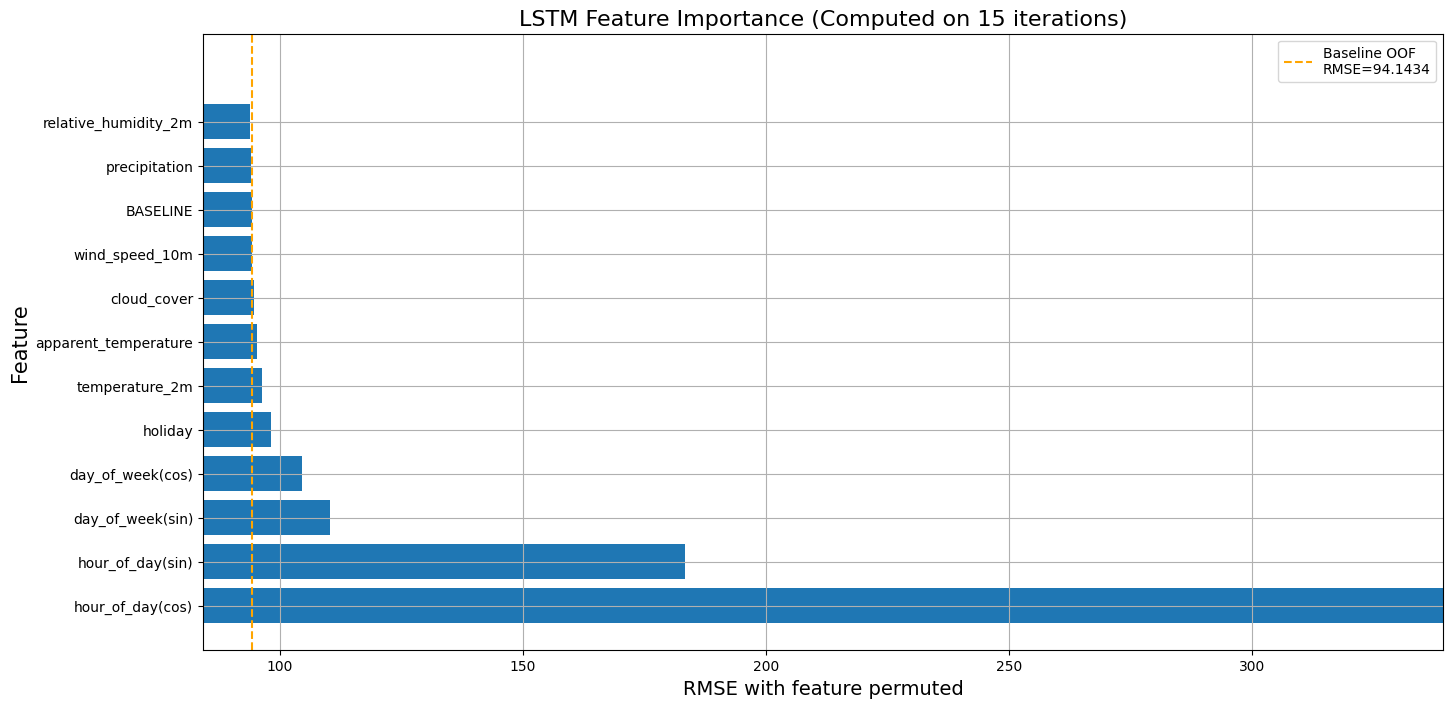

,feature,RMSE
0,hour_of_day(cos),339.303054
1,hour_of_day(sin),183.390305
2,day_of_week(sin),110.279067
3,day_of_week(cos),104.421584
4,holiday,98.087373
5,temperature_2m,96.366154
6,apparent_temperature,95.211955
7,cloud_cover,94.565201
8,wind_speed_10m,94.287257
9,BASELINE,94.143430


In [46]:
results = results[results.feature != "hourly_traffic"]
results = results.sort_values(metric, ascending=False).reset_index(drop=True)
plt.figure(figsize=(16, 8))

plt.barh(results.feature, results[metric])

plt.yticks(results.feature, results.feature.values)
plt.xlim(left=0.03, right=max(results[results.feature != "hourly_traffic"][metric]))
plt.xlabel(f"{metric} with feature permuted", size=14)
plt.ylabel("Feature", size=15)

plt.title(f"LSTM Feature Importance (Computed on {iterations} iterations)", size=16)

plt.plot(
    [baseline, baseline],
    [-1, len(X_col) + 1],
    "--",
    color="orange",
    label=f"Baseline OOF\n{metric}={baseline:.4f}",
)
plt.xlim(left=baseline-10)
plt.margins(0)
plt.legend()
plt.grid()
plt.savefig("img/Feature_importance/Permutation_Importance.svg")
plt.show()
results.to_csv("img/Feature_importance/Permutation_Importance.csv")
display(results)